# MLFLOW Training example


Similar to the problem in the MLflow example https://www.mlflow.org/docs/latest/tutorials-and-examples/tutorial.htm but instead, we predict the _price_ of the airbnb properties in the Berlin area

C Fanara 

v1.4 - 30 september 2021
rev  22 october 2021

____________ 
General plan for the following
1. specialize to other problems
2. save to the python script version - e.g. propagate modifs done here to script
Reason to run like that is that we go past training - this notebook - in order to do
(following the link https://www.mlflow.org/docs/latest/tutorials-and-examples/tutorial.html):
3. comparison of models by running the flow
4. compare to the list of experiments: useful for lab as well!
5. package the training code in a conda env - better to change the name of the env and dependences accordingly - see folder or link above
6. run with the appropriate parameter, here only alpha
7. serve the model


After completion of the pipeline:

8. add other regressors
and generalize, e.g.
9. use my one-for-all regressor
10. compare the pyCaret pipeline
11. can we add shap on a per-model base?


# 1. Import data and training function
All the elements as a function for later export to script
We assume dat read from the pickle are cleaned by a previous VIZ-EDA step

In [51]:
def train(in_alpha, in_l1_ratio, rng):
    import os
    import warnings
    import sys

    import pandas as pd
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import ElasticNet

    import mlflow
    import mlflow.sklearn
    
    import logging
    logging.basicConfig(level=logging.WARN)
    logger = logging.getLogger(__name__)

    def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2


    warnings.filterwarnings("ignore")
    np.random.seed(40)

    # Read csv file from the URL, ex.
    #csv_url =\
    #    'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        # data= pd.read_pickle('/home/carlo/Documents/MLFlow/listing_pro_regr_proc_df.zip')
         data= pd.read_pickle('/home/carlo/Documents/MLFlow/listing_IN_regr_proc_df.zip')
    #try:
    #     data = pd.read_csv(csv_url, sep=';')
    except Exception as e:
        logger.exception(
            "Unable to find training & test CSV, check location. Error: %s", e)
      
    # Split the data into training and test sets. (0.75, 0.25) split.
    train, test = train_test_split(data)

    # The predicted column is a scalar
    train_x = train.drop(["price"], axis=1)
    test_x = test.drop(["price"], axis=1)
    train_y = train[["price"]]
    test_y = test[["price"]]

    # Set default values if no alpha is provided
    if float(in_alpha) is None:
        alpha = 0.5
    else:
        alpha = float(in_alpha)

    # Set default values if no l1_ratio is provided
    if float(in_l1_ratio) is None:
        l1_ratio = 0.5
    else:
        l1_ratio = float(in_l1_ratio)

    # Useful for multiple runs (only doing one run in this sample notebook)    
    with mlflow.start_run():
        # Execute ElasticNet
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=rng, selection='random')
        lr.fit(train_x, train_y)

        # Evaluate Metrics
        predicted_qualities = lr.predict(test_x)
        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

        # Print out metrics
        print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(lr, "model") # may be more explicit to 

# 2. Check input file

<AxesSubplot:>

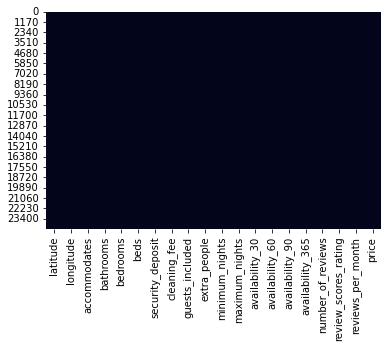

In [52]:
# before launching, just check what we are sending
import seaborn as sns
import pandas as pd
# data= pd.read_pickle('/home/carlo/Documents/MLFlow/listing_pro_regr_proc_df.zip')
data= pd.read_pickle('/home/carlo/Documents/MLFlow/listing_IN_regr_proc_df.zip')
sns.heatmap(data.isnull(), cbar=False)    
        
     

# 3. Run individual tests

In [53]:
import numpy as np
rng = np.random.RandomState(0)
train(0.5, 0.5, rng)

Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 49.711689672717235
  MAE: 25.312709725921867
  R2: 0.2967551394539836


In [54]:
import numpy as np
rng = np.random.RandomState(0)
train(0.2, 0.2, rng)

Elasticnet model (alpha=0.200000, l1_ratio=0.200000):
  RMSE: 49.57420774217913
  MAE: 25.28092856836487
  R2: 0.3006395283578077


In [55]:
import numpy as np
rng = np.random.RandomState(0)
train(0.1, 0.1,rng)

Elasticnet model (alpha=0.100000, l1_ratio=0.100000):
  RMSE: 49.482207341804596
  MAE: 25.29376800089534
  R2: 0.303232882584511


#### Note
This was cross-checked with my protocol on 90PoE and the train RMSE is somewhat 0.1 lower here, but here we did 3 iterations varying params, there we did 10 repetitions for stats purposes

#### todo
Use a gui /accept user parameter "nr. of iterations"

# 4. Run repeated tests (loop)

In [56]:
# External loop to perform training and test k times. 
k = 7   # several files were run with 5, 10, 15, 20. Can decide a standard when plotting metrics vs repetitions and seek plateau - if any

# first element, 0, is header
for i in range(1, k):  
    rng = np.random.RandomState()  # we impose different rnd
    train(0.5, 0.5, rng)
    

Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 49.71178784303971
  MAE: 25.312696908990855
  R2: 0.29675236192445853
Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 49.71179959585292
  MAE: 25.31261937505121
  R2: 0.2967520294021546
Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 49.71173486672014
  MAE: 25.31264567599246
  R2: 0.2967538607823098
Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 49.71199052811764
  MAE: 25.31271016726346
  R2: 0.29674662734523327
Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 49.71182137872841
  MAE: 25.312620505535147
  R2: 0.29675141309912545
Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 49.711719358925976
  MAE: 25.31266014037511
  R2: 0.2967542995436888


# 5. Evaluations 
would be done on the upgraded version. This is basic, dev for this version stops here (20 October 2021)